<a href="https://colab.research.google.com/github/sholtodouglas/AI_papers_network_graph/blob/master/working_notebook_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
colab = True
old = True

In [32]:

#@title Install { display-mode: "form" }
if colab:
    TF_Installation = 'TF2 Nightly (GPU)' #@param ['TF2 Nightly (GPU)', 'TF2 Stable (GPU)', 'TF1 Nightly (GPU)', 'TF1 Stable (GPU)','System']

    if TF_Installation == 'TF2 Nightly (GPU)':
      !pip install -q --upgrade tf-nightly-gpu-2.0-preview
      print('Installation of `tf-nightly-gpu-2.0-preview` complete.')
    elif TF_Installation == 'TF2 Stable (GPU)':
      !pip install -q --upgrade tensorflow-gpu==2.0.0-alpha0
      print('Installation of `tensorflow-gpu==2.0.0-alpha0` complete.')
    elif TF_Installation == 'TF1 Nightly (GPU)':
      !pip install -q --upgrade tf-nightly-gpu
      print('Installation of `tf-nightly-gpu` complete.')
    elif TF_Installation == 'TF1 Stable (GPU)':
      !pip install -q --upgrade tensorflow-gpu
      print('Installation of `tensorflow-gpu` complete.')
    elif TF_Installation == 'System':
      pass
    else:
      raise ValueError('Selection Error: Please select a valid '
                       'installation option.')

Installation of `tf-nightly-gpu-2.0-preview` complete.


In [33]:
#@title Install { display-mode: "form" }
if colab:
    TFP_Installation = "Nightly" #@param ["Nightly", "Stable", "System"]

    if TFP_Installation == "Nightly":
      !pip install -q tfp-nightly
      print("Installation of `tfp-nightly` complete.")
    elif TFP_Installation == "Stable":
      !pip install -q --upgrade tensorflow-probability
      print("Installation of `tensorflow-probability` complete.")
    elif TFP_Installation == "System":
      pass
    else:
      raise ValueError("Selection Error: Please select a valid "
                       "installation option.")

Installation of `tfp-nightly` complete.


In [0]:
#@title Upgrade PyPI Packages { display-mode: "form" }
if colab:
    !pip install --upgrade pandas -q

In [35]:
#@title Import { display-mode: "form" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

# print(tf2.enabled())

import tensorflow_probability as tfp

import tensorflow_datasets as tfds


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


from tensorflow.keras.layers import Dense, Flatten, Conv2D,Bidirectional, LSTM, Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import Model
from tensorflow.keras.models import  Sequential
import matplotlib.pyplot as plt
import datetime
import os
from tqdm import tqdm, tqdm_notebook
import random
from natsort import natsorted, ns
import imageio
from IPython import display
from PIL import Image
from IPython.display import clear_output
import IPython
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import pandas as pd

print('Importing viz libraries...')
# Load the TensorBoard notebook extension
if colab:
    %load_ext tensorboard
    # Clear any logs from previous runs
    #!rm -rf ./logs/ 
    %tensorboard --logdir logs/gradient_tape
print('Tensorflow version (should be >= 2.0): '+tf.__version__)
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')

else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

Importing viz libraries...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1733: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Reusing TensorBoard on port 6006 (pid 343), started 4:30:10 ago. (Use '!kill 343' to kill it.)

Tensorflow version (should be >= 2.0): 2.0.0-dev20190506
SUCCESS: Found GPU: /device:GPU:0


# Hyperparameters

In [0]:
BATCH_SIZE = 256
MIN_SEQ_LEN = 10
MAX_SEQ_LEN = 10

LATENT_DIM = 120

ACTION_DIM = 8
NUM_DISTRIBUTIONS = 3 # how many distributions make up the multinomial distrib for each action dim
NUM_QUANTISATIONS = 256 # how many bins to split the action space into
MAX_EVER_SEQ_LEN = MAX_SEQ_LEN
EPOCHS = 100
if old:
    OBS_DIM = 35
    LAYER_SIZE = 1000
else:
    OBS_DIM = 36
    LAYER_SIZE = 2048
P_DROPOUT = 0.1
DISCRETIZED = False
RELATIVE = True # actions are relative to current position

BETA = 0.0001 # Planner/Encoder KL divergence weighting
ALPHA = 0.1 #  Auxiliary loss weighting on nextstate prediction).

# Data Collection

In [7]:
#@title Pull data from remote and build tf dataset

if not os.path.exists("data_and_weights"):
    print('Pulling demo data and NN weights from Google Drive... (takes ~30s)')
    # Pull the robotic demonstration data and trained weights from google drive
    !wget --no-check-certificate -r "https://docs.google.com/uc?export=download&id=1Eo3rNbolc-LB8w7uSmv9o3yflJWNNJ_I" -O data.zip -q
    print('Finished downloading')
    print('Unzipping data file...')
    !unzip -q data.zip 
    print('Data unzipped successfully')
else:
    print('Data already exists, ready to load...')

path= 'data_and_weights/play_data/set_0'
path2= 'data_and_weights/play_data/set2'
path3= 'data_and_weights/play_data/set3'
# collect all file paths
moments = [x[0] for x in os.walk(path)][1:]  + [x[0] for x in os.walk(path2)][1:] + [x[0] for x in os.walk(path3)][1:]
# sort them according to timestamp
moments = natsorted(moments, alg=ns.IGNORECASE)

print('Loading data into memory...')
def load_data_into_memory(moments):
    observations = []
    actions  = []
    imgs = []

    for s in tqdm_notebook(moments):
        act = np.load(s+'/act.npy')
        actions.append(act)
        obs = np.load(s+'/obs.npy')
        observations.append(obs)
        #imgs.append(imageio.imread(s+'/standard_cam_left.jpg'))
        # do the other image ones later
        
    return np.array(observations).astype(float), np.array(actions).astype(float), np.array(imgs)

if len(moments) > 0:
    observations, actions, imgs = load_data_into_memory(moments)
else:
    observations = np.load(data_path+'observations.npy')
    actions = np.load(data_path+'actions.npy')
  

print('Computing statistics on dataset...')
def find_means_variances_ranges(input):
    mean = np.mean(input, axis = 0)
    std = np.std(input, axis  = 0)
    maxes = input.max(axis = 0)
    mins = input.min(axis = 0)
    
    return mean, std, maxes, mins
    
mean_obs, std_obs, _,_ = find_means_variances_ranges(observations)
mean_acts, _, maxes_acts, mins_acts  = find_means_variances_ranges(actions)


print('Standardizing dataset...')
def standardize(observations, mean_obs, std_obs):
    return observations
    #return (observations - mean_obs) /std_obs
    
standardized_obs = standardize(observations, mean_obs, std_obs)

#lets exclude arm joint position and velocity. 
# our observations are 8x arm pos, 8x arm vel, 7x arm pos+rot, 7x4 object pos+rot. 
if old:
    standardized_obs = standardized_obs[:,16:]
else:
    standardized_obs = np.concatenate((np.expand_dims(standardized_obs[:,6], axis = 1), standardized_obs[:,16:]), axis = 1)

# subtract the current state xyz pos quat from the action, so its all relative to the current state. 
if RELATIVE:
    actions[:,:7] = actions[:,:7] - observations[:,16:23]
    
if DISCRETIZED:
    actions_rounded = (actions*NUM_QUANTISATIONS/2).astype(int).astype('float32') #cast to int,then back to float 32 for tensorflow
    actions = np.clip(actions_rounded, -NUM_QUANTISATIONS/2, NUM_QUANTISATIONS/2) # clip the range
    

train_len = int(len(observations)*0.9)
train_obs_subset = standardized_obs[:train_len,:]
train_acts_subset = actions[:train_len,:]

valid_obs_subset = standardized_obs[train_len:,:]
valid_acts_subset = actions[train_len:,:]

train_moments_subset = moments[:train_len]
valid_moments_subset = moments[train_len:]
train_idxs = len(train_obs_subset)-MAX_EVER_SEQ_LEN
valid_idxs = len(valid_obs_subset)-MAX_EVER_SEQ_LEN #SO IF MAX_SEQ_LEN is curriculum trained we don't mess up. 
TRAIN_LEN = train_idxs
VALID_LEN = valid_idxs
    
print('Building tf dataset...')
def generator(observations,actions, subset, images = False):
    

    if subset == b'Train':
        idxs = train_idxs
        obs_set = train_obs_subset
        act_set = train_acts_subset
        moments_set = train_moments_subset
    if subset == b'Valid':
        idxs = valid_idxs
        obs_set = valid_obs_subset
        act_set = valid_acts_subset
        moments_set = valid_moments_subset
        
    
    for idx in range(0, idxs):
        # yield the observation randomly between min and max sequence length.
        length = np.random.randint(MIN_SEQ_LEN,MAX_SEQ_LEN+1)
        obs_padding = np.zeros((MAX_SEQ_LEN-length, OBS_DIM))

        if obs_padding.shape[0]+length != MAX_SEQ_LEN:
            print(obs_padding.shape[0],length)
        padded_obs = np.concatenate((obs_set[idx:idx+length], obs_padding), axis = 0)

        act_padding = np.zeros((MAX_SEQ_LEN-length, ACTION_DIM))
        padded_act = np.concatenate((act_set[idx:idx+length], act_padding), axis = 0)
                
        if images == True:
            viz_imgs = []

            img_paths = moments_set[idx:idx+length]
            for s in img_paths:
                viz_imgs.append(imageio.imread(s+'/standard_cam_left.jpg')) # images not yet padded

            viz_imgs = np.array(viz_imgs)
            yield(padded_obs, padded_act, viz_imgs)
        else:
            yield (padded_obs, padded_act)


dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32), args = (standardized_obs, actions,'Train'))
valid_dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32), args = (standardized_obs, actions,'Valid'))

viz_dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32, tf.int8), args = (standardized_obs, actions,'Train', True))
viz_valid_dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32, tf.int8), args = (standardized_obs, actions,'Valid', True))


Data already exists, ready to load...
Loading data into memory...


W0507 06:28:33.740053 140303944353664 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:472: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    



Computing statistics on dataset...
Standardizing dataset...
Building tf dataset...


In [18]:
if not os.path.exists("test_weights"):
    print('Pulling demo data and NN weights from Google Drive... (takes ~30s)')
    # Pull the robotic demonstration data and trained weights from google drive
    !wget --no-check-certificate -r "https://docs.google.com/uc?export=download&id=1Eo3rNbolc-LB8w7uSmv9o3yflJWNNJ_I" -O test_weights.zip -q
    print('Finished downloading')
    print('Unzipping data file...')
    !unzip -q test_weights.zip 
    print('Data unzipped successfully')
else:
    print('Data already exists, ready to load...')

Data already exists, ready to load...


In [17]:
!ls


data_and_weights      data.zip	sample_data
data_and_weights.zip  logs	test_weights


# Model

In [0]:
#@title Define NN Architecture
# Planner, 4 layers of 1000, + mu and std layers. 
class PLANNER(Model):
  def __init__(self):
    super(PLANNER, self).__init__()

    self.d1 = Dense(LAYER_SIZE, activation='relu')
    self.d2 = Dense(LAYER_SIZE, activation='relu')
    self.d3 = Dense(LAYER_SIZE, activation='relu')
    if old:
        self.d4 = Dense(LAYER_SIZE, activation='relu')
    self.mu = Dense(LATENT_DIM)
    self.scale = Dense(LATENT_DIM, activation='softplus')
    
    self.dropout1 = tf.keras.layers.Dropout(P_DROPOUT)
    self.dropout2 = tf.keras.layers.Dropout(P_DROPOUT)
    

  def call(self, s_i, s_g, training = False):
    x = tf.concat([s_i,s_g], axis = 1)
    x = self.d1(x)
    x = self.dropout1(x, training = training)
    x = self.d2(x)
    x = self.dropout2(x, training = training)
    x = self.d3(x)
    if old:
        x = self.d4(x)
    mu = self.mu(x)
    s = self.scale(x)
    
    return mu, s


class TRAJECTORY_ENCODER_LSTM(Model):
  def __init__(self):
    super(TRAJECTORY_ENCODER_LSTM, self).__init__()
    
    self.bi_lstm = Bidirectional(CuDNNLSTM(LAYER_SIZE, return_sequences=True), merge_mode=None)
    if old:
        self.D1 = Dense(LAYER_SIZE, activation='relu')
    self.mu = Dense(LATENT_DIM)
    self.scale = Dense(LATENT_DIM, activation='softplus')
    

  def call(self, obs, acts):
    x = tf.concat([obs,acts], axis = 2) # concat observations and actions together.
    x = self.bi_lstm(x)
    bottom = x[0][:,-1, :] # Take the last element of the bottom row
    top = x[1][:,0,:] # Take the first elemetn of the top row cause Bidirectional, top row goes backward.
    x = tf.concat([bottom, top], axis = 1)
    if old:
        x = self.D1(x)
    mu = self.mu(x)
    s = self.scale(x)
    
    return mu, s



class ACTOR(Model):
  def __init__(self):
    super(ACTOR, self).__init__()
    
    self.d1 = Dense(LAYER_SIZE, activation='relu')
    self.d2 = Dense(LAYER_SIZE, activation='relu')
    self.d3 = Dense(LAYER_SIZE, activation='relu')
    self.d4 = Dense(LAYER_SIZE, activation='relu')
    self.mu = Dense(ACTION_DIM*NUM_DISTRIBUTIONS) #means of our logistic distributions
    # softplus activations are to ensure positive values for scale and probability weighting.
    self.scale = Dense(ACTION_DIM*NUM_DISTRIBUTIONS,activation='softplus') # scales of our logistic distrib
    self.prob_weight = Dense(ACTION_DIM*NUM_DISTRIBUTIONS,activation='softplus') # weightings on each of the distribs.
    self.next_obs_pred = Dense(OBS_DIM)
    
    self.dropout1 = tf.keras.layers.Dropout(P_DROPOUT)
    self.dropout2 = tf.keras.layers.Dropout(P_DROPOUT)
    self.dropout3 = tf.keras.layers.Dropout(P_DROPOUT)
    self.dropout4 = tf.keras.layers.Dropout(P_DROPOUT)
    

  def call(self, s, z, s_g, training = False):
    x = tf.concat([s, z, s_g], axis = 1)
    x = self.dropout1(x, training=training)
    x = self.d1(x)
    #print(p_dropout)
    x = self.dropout2(x, training=training)
    x = self.d2(x)
    x = self.dropout3(x, training=training)
    if old:
        x = self.d3(x)
        x = self.dropout4(x, training=training)
        x = self.d4(x)
 
    
    
    mu = tf.reshape(self.mu(x), [-1,ACTION_DIM, NUM_DISTRIBUTIONS])
    scale = tf.reshape(self.scale(x), [-1,ACTION_DIM, NUM_DISTRIBUTIONS])
    #scale = tf.ones((scale.shape[0], ACTION_DIM, NUM_DISTRIBUTIONS))*0.00001 
    prob_weight = tf.reshape(self.prob_weight(x), [-1,ACTION_DIM, NUM_DISTRIBUTIONS])
    if DISCRETIZED:
        # multiply mean by 64 so that for a neuron between -2 and 2, it covers the full range 
        # between -128 and 128, i.e so the weights don't have to be huge! in the mean layer, but tiny in the s and prob layers.
        mu = mu*NUM_QUANTISATIONS/4
        discretized_logistic_dist = tfd.QuantizedDistribution(distribution=tfd.TransformedDistribution(
            distribution=tfd.Logistic(loc=mu,scale=scale),bijector=tfb.AffineScalar(shift=-0.5)),
        low=-NUM_QUANTISATIONS/2,
        high=NUM_QUANTISATIONS/2)

        # should be batch size by action dim
        distributions = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                probs=prob_weight),components_distribution=discretized_logistic_dist)
    else:
        logistic_dist = tfd.Logistic(loc=mu,scale=scale)

        distributions = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                probs=prob_weight),components_distribution=logistic_dist)
    
    
    
    obs_pred = self.next_obs_pred(x)
    
    
    return mu,scale, prob_weight, distributions, obs_pred

In [0]:
#@title Init Model
planner = PLANNER()
encoder = TRAJECTORY_ENCODER_LSTM()
actor = ACTOR()




In [0]:
#@title Train/Test/Loss functions


def avg_seq_len():
    return (MAX_SEQ_LEN+MIN_SEQ_LEN)/2

@tf.function
def compute_loss(normal_plan, normal_enc, z, obs, acts, s_g, actor, training=False):
    # Automatically averaged over batch size i.e. SUM_OVER_BATCH_SIZE
    KL = tf.reduce_sum(tfd.kl_divergence(normal_enc, normal_plan)) #KL divergence between encoder and planner distirbs
#     KL =  tf.losses.KLDivergence(normal_enc, normal_plan) #KL divergence between encoder and planner distirbs
    
    # Vectorize this like my pytorch version for efficiency later using tile
    IMI = 0
    OBS_pred_loss = 0
    entropy = 0
    for t in range(0,MAX_SEQ_LEN):
        s = obs[:,t,:]
        a = acts[:,t,:]
        
        mu, scale, prob_weight, pdf, obs_pred= actor(s,z,s_g, training = training)
        IMI +=   tf.reduce_sum(-pdf.log_prob(a))
        entropy += tf.reduce_sum(pdf[:,:ACTION_DIM-1].log_prob(tf.zeros((1,ACTION_DIM-1)))) # ENCOURAGE IT to get away from 0.Except the gripper, gripper can do what it wants.
        
        # log probability of the true actions under the provided distributions
        OBS_pred_loss += tf.losses.MSE(obs[:,t,:], obs_pred)

    
    AVG_SEQ_LEN = avg_seq_len()
    
    IMI = (IMI/AVG_SEQ_LEN)/BATCH_SIZE
    OBS_pred_loss = (OBS_pred_loss/AVG_SEQ_LEN)/BATCH_SIZE # optional next state prediction loss.
    entropy = entropy/AVG_SEQ_LEN/BATCH_SIZE
    
    loss = IMI + BETA*KL + ALPHA*entropy# + OBS_pred_loss*ALPHA
    
    return loss, IMI, KL, entropy
    
    
    
# TODO: plan still being sampled from encoder not planner    
@tf.function
def train_step(obs, acts):
  with tf.GradientTape() as tape:
    
    # obs and acts are a trajectory, so get intial and goal
    s_i = obs[:,0,:]
    s_g = obs[:,-1,:]

    # Encode the trajectory
    mu, s = encoder(obs, acts)
    encoder_normal = tfd.Normal(mu,s)
    z = encoder_normal.sample()
    
    #Produce a plan from the inital and goal state
    mu, s = planner(s_i,s_g, training = True)
    planner_normal = tfd.Normal(mu,s)
    #z = planner_normal.sample()
    
    #Compute all losses
    loss, IMI, KL, entropy = compute_loss(planner_normal, encoder_normal, z, obs, acts, s_g, actor, training = True)
  #find and apply gradients with total loss
  gradients = tape.gradient(loss,encoder.trainable_variables+planner.trainable_variables+actor.trainable_variables)
  optimizer.apply_gradients(zip(gradients,encoder.trainable_variables+planner.trainable_variables+actor.trainable_variables))
    
  # return values for diagnostics
  return IMI, KL, entropy
    
    
@tf.function
def test_step(obs, acts):   
    s_i = obs[:,0,:]
    s_g = obs[:,-1,:]
    
    # Encode Trajectory 
    mu, s = encoder(obs, acts)
    encoder_normal = tfd.Normal(mu,s)
    z = encoder_normal.sample()
    
    # PLan with si,sg.
    mu, s = planner(s_i,s_g)
    planner_normal = tfd.Normal(mu,s)
    z = planner_normal.sample()
    
    _, IMI, KL, OBS_pred_loss = compute_loss(planner_normal, encoder_normal, z, obs, acts, s_g, actor)
    
    return IMI, KL


In [0]:
def load_weights(extension, actor, planner, encoder):
    print('Loading in network weights...')
    # load some sample data to initialise the model
    load_set = iter(dataset.shuffle(TRAIN_LEN).batch(BATCH_SIZE))
    obs  = tf.zeros((BATCH_SIZE,MAX_SEQ_LEN,OBS_DIM))
    acts = tf.zeros((BATCH_SIZE,MAX_SEQ_LEN,ACTION_DIM))
    
    IMI, KL, _ = train_step(obs, acts)
    
    planner.load_weights(extension+'/planner.h5')
    encoder.load_weights(extension+'/encoder.h5')
    actor.load_weights(extension+'/actor.h5')
    print('Loaded.')
    return actor, planner, encoder


def save_weights(extension):
    try:
        
        os.mkdir(extension)
    except Exception as e:
        #print(e)
        pass
        
    #print(extension)
    actor.save_weights(extension+'/actor.h5')
    planner.save_weights(extension+'/planner.h5')
    encoder.save_weights(extension+'/encoder.h5')

In [0]:

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [20]:
#@title Optionally Load Weights
extension = 'test_weights/BESTBESTdB0.0001-D0.Morelayers'
#extension = 'data_and_weights/saved_models/B0_001BESBTEST'
#extension = '../saved_models/standardizedgripperb002SQL23'
#extension = '../saved_models/zeropenalty'+'SQL11'
actor, planner, encoder = load_weights(extension, actor, planner, encoder)



Loading in network weights...
Loaded.


In [0]:

#@title Create logging dir 

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'-Beta:'+str(BETA)+'-Latent:'+str(LATENT_DIM)+'Drp'+str(P_DROPOUT)+''
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
steps = 0

#extension = 'data_and_weights/saved_models/relative_ctsB0.3-D0.3Morelayers'
# extension = 'data_and_weights/saved_models/BESTBESTdB0.0001-D0.Morelayers'

In [0]:
# extension = '../saved_models/FINALB0_0001'+'SQL11'
# actor, planner, encoder = load_weights(extension, actor, planner, encoder)
# seto = iter(dataset.shuffle(VALID_LEN).batch(BATCH_SIZE))
# obs,acts = seto.next()
# IMI, KL, entropy = train_step(obs,acts)
# print(IMI, KL, entropy)

# Training Loop

In [0]:
#@title Train Model
IMI_val, KL_val = np.Inf, np.Inf
MIN_SEQ_LEN = 10
MAX_SEQ_LEN = 10
dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32), args = (standardized_obs, actions,'Train'))
valid_dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32), args = (standardized_obs, actions,'Valid'))
  
for epoch in tqdm_notebook(range(EPOCHS), 'Epoch '):
    train_set = dataset.shuffle(TRAIN_LEN).batch(BATCH_SIZE)
    valid_set = iter(valid_dataset.shuffle(VALID_LEN).batch(BATCH_SIZE))
    for obs,acts in train_set:
        IMI, KL, entropy = train_step(obs,acts)
        print("\r",f"Epoch {epoch}\t| TRAIN | IMI: {float(IMI):.2f}, KL: {float(KL):.2f}\
        TEST | IMI: {float(IMI_val):.2f}, KL: {float(KL_val):.2f}",end="")
        
        with train_summary_writer.as_default():
            tf.summary.scalar('imi_loss', IMI, step=steps)
            tf.summary.scalar('kl_loss', KL, step=steps)
            #tf.summary.scalar('OBS_pred_loss ', OBS_pred_loss, step=steps)

        if steps % 100 == 0:
            valid_obs, valid_acts = valid_set.next()
            IMI, KL = test_step(valid_obs, valid_acts)
            IMI_val, KL_val = IMI, KL
            with test_summary_writer.as_default():
                tf.summary.scalar('imi_loss', IMI, step=steps)
                tf.summary.scalar('kl_loss', KL, step=steps)
            
        steps +=1

 Epoch 1	| TRAIN | IMI: -27.56, KL: 4940.89        TEST | IMI: -24.86, KL: 10560.47

KeyboardInterrupt: 

In [0]:
MIN_SEQ_LEN = 9
MAX_SEQ_LEN = 11
threshold = -23.0
best_val_loss = 0

IMI_val, KL_val = np.Inf, np.Inf

dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32), args = (standardized_obs, actions,'Train'))
valid_dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32), args = (standardized_obs, actions,'Valid'))
  
for epoch in tqdm_notebook(range(EPOCHS), 'Epoch '):
    
    
    if IMI_val <= threshold and MAX_SEQ_LEN<=MAX_EVER_SEQ_LEN:
        best_val_loss = 0 # reset it so we save weights for the new sequence length
        MAX_SEQ_LEN += 1
        if MIN_SEQ_LEN <= 10:
            MIN_SEQ_LEN += 1
        print('Sequence Length now:', MIN_SEQ_LEN, '-', MAX_SEQ_LEN)
        # recreate our dataset with the new sequence length
        dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32), args = (standardized_obs, actions,'Train'))
        valid_dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32), args = (standardized_obs, actions,'Valid'))

    
    train_set = dataset.shuffle(TRAIN_LEN).batch(BATCH_SIZE)
    valid_set = iter(valid_dataset.shuffle(VALID_LEN).batch(BATCH_SIZE))
    for obs,acts in train_set:
        IMI, KL, entropy = train_step(obs,acts)
        print("\r",f"Epoch {epoch}\t| TRAIN | IMI: {float(IMI):.2f}, KL: {float(KL):.2f}\
        TEST | IMI: {float(IMI_val):.2f}, KL: {float(KL_val):.2f}, , entropy: {float(entropy):.2f}",end="")
        
        with train_summary_writer.as_default():
            tf.summary.scalar('imi_loss', IMI, step=steps)
            tf.summary.scalar('kl_loss', KL, step=steps)
            #tf.summary.scalar('OBS_pred_loss ', OBS_pred_loss, step=steps)

        if steps % 100 == 0:
            valid_obs, valid_acts = valid_set.next()
            IMI, KL = test_step(valid_obs, valid_acts)
            IMI_val, KL_val = IMI, KL
            with test_summary_writer.as_default():
                tf.summary.scalar('imi_loss', IMI, step=steps)
                tf.summary.scalar('kl_loss', KL, step=steps)
            
        steps +=1
        
    if IMI_val < best_val_loss:
        best_val_loss = IMI_val
        print('Saving Weights, best loss encountered')
        extension = 'saved_models/zeropenalty'+'SQL'+str(MAX_SEQ_LEN)
        save_weights(extension)

W0506 06:18:04.791699 140367633745728 optimizer_v2.py:928] Gradients does not exist for variables ['actor/dense_14/kernel:0', 'actor/dense_14/bias:0'] when minimizing the loss.


 Epoch 0	| TRAIN | IMI: -20.01, KL: 4193.29        TEST | IMI: -18.63, KL: 12959.19, , entropy: 20.363

W0506 06:18:51.092315 140367633745728 optimizer_v2.py:928] Gradients does not exist for variables ['actor/dense_14/kernel:0', 'actor/dense_14/bias:0'] when minimizing the loss.


 Epoch 0	| TRAIN | IMI: -15.78, KL: 3254.82        TEST | IMI: -18.63, KL: 12959.19, , entropy: 15.91Saving Weights, best loss encountered
 Epoch 1	| TRAIN | IMI: -17.05, KL: 3251.91        TEST | IMI: -20.20, KL: 12055.23, , entropy: 15.83Saving Weights, best loss encountered
 Epoch 2	| TRAIN | IMI: -18.43, KL: 3018.16        TEST | IMI: -21.25, KL: 10685.35, , entropy: 16.228Saving Weights, best loss encountered
 Epoch 3	| TRAIN | IMI: -17.62, KL: 3158.42        TEST | IMI: -22.49, KL: 10552.24, , entropy: 8.90Saving Weights, best loss encountered
 Epoch 4	| TRAIN | IMI: -18.49, KL: 3254.77        TEST | IMI: -23.92, KL: 12406.19, , entropy: 7.5139Saving Weights, best loss encountered
 Epoch 7	| TRAIN | IMI: -19.14, KL: 2869.39        TEST | IMI: -25.01, KL: 9380.62, , entropy: 16.002277Saving Weights, best loss encountered
 Epoch 9	| TRAIN | IMI: -24.13, KL: 3618.25        TEST | IMI: -23.44, KL: 12920.13, , entropy: 20.23

In [0]:
#@title Save weights

# extension = '../data_and_weights/saved_models/'
# save_weights(extension)

# Visualisation

In [0]:
#@title Prepare data for viz

# Functions 
# Functions 
def get_z_and_info(trajectory):
    moments = [x[0] for x in os.walk(trajectory)][1:]
    moments = natsorted(moments, alg=ns.IGNORECASE)
    
    states = []
    actions = []
    
    for t in moments:
        o = standardize(np.load(t+'/obs.npy'),mean_obs, std_obs)
        o[6] = o[6]*25
        if old:
            o = o[16:]
        else:
            o = np.concatenate((np.expand_dims(o[6], axis = 0), o[16:]), axis = 0)
        states.append(tf.expand_dims(tf.constant(o), axis = 0))
        actions.append(tf.expand_dims(tf.constant(np.load(t+'/act.npy')), axis = 0))
        
    s_i =  states[0]
    s_g =  states[-1]
    
    
    mu, s = planner(s_i,s_g)
    mu_t, s_t = encoder(np.transpose(np.array(states),(1,0,2)).astype('float32'), np.transpose(np.array(actions),(1,0,2)).astype('float32'))
    
    
    return mu, trajectory.replace(path,''), mu_t
  
def label_color(row):
    return row['labels'][0]

def label_task(row):
    label = row['labels']
    tasks = ['stack', 'pick', 'push', 'place', 'tip']
    for t in tasks:
        if t in label:
            return t
    return '-'
        
def label_direction(row):
    label = row['labels']
    directions = ['center', 'right', 'left', 'back', 'forward']
    for t in directions:
        if t in label:
            return t
    return '-'



%matplotlib inline
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

path= '../data_and_weights/play_data/positive_demos/'
pos_trajectories = next(os.walk(path))[1]  
 
  
print('Generating encodings from network... (this takes a short while)')
zs = []
z_ts = [] # zs from the encoder
infos = []
for t in tqdm_notebook(pos_trajectories):
    z, info, z_t = get_z_and_info(path+t)
#     print(z.shape, z_t.shape)
    zs.append(np.array(z))
    z_ts.append(np.array(z_t))
    
    infos.append(info.split('_'))
    
d = {'planner_embeddings':zs, 'labels': infos, 'encoder_embeddings':z_ts}
df = pd.DataFrame(data=d)
df['color'] = df.apply(label_color, axis=1)
df['task'] = df.apply(label_task, axis=1)
df['direction'] = df.apply(label_direction, axis=1)


print('Sampling data to visualize...')
viz_set = iter(valid_dataset.shuffle(VALID_LEN).batch(500))


obs,acts = viz_set.next()
s_i = obs[:,0,:]
s_g = obs[:,-1,:]
mu, s = planner(s_i,s_g)
mu_t, s_t = encoder(obs,acts)


for i in range(len(mu)):
    df = df.append({'planner_embeddings': np.expand_dims(mu[i], axis = 0), 'encoder_embeddings': np.expand_dims(mu_t[i], axis = 0), 'labels':'-', 'color':'-', 'task': '-', 'direction':'-'}, ignore_index=True)
    

planner_embeddings =  np.vstack(df['planner_embeddings'].to_numpy())
encoder_embeddings =  np.vstack(df['encoder_embeddings'].to_numpy())
print('Done')

Generating encodings from network... (this takes a short while)



Sampling data to visualize...
Done


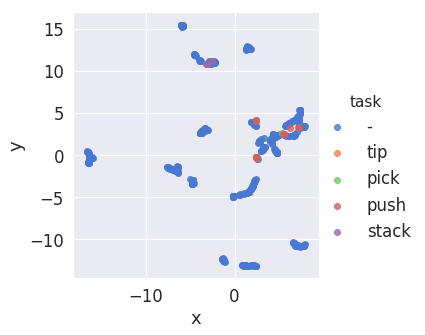

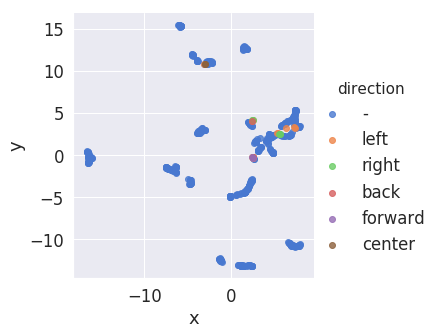

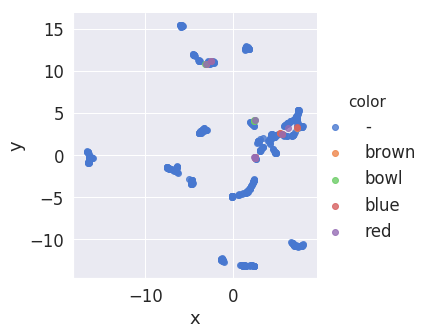

In [0]:
#@title UMAP Planner Embedding Viz
# reduced_embedding = TSNE().fit_transform(embeddings)
reduced_planner_embedding = umap.UMAP().fit_transform(planner_embeddings);
df['x'] = reduced_planner_embedding[:,0]
df['y']  = reduced_planner_embedding[:,1]
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="x", y="y", data=df.iloc[::-1], fit_reg=False, hue='task', legend=True);
sns.lmplot( x="x", y="y", data=df.iloc[::-1], fit_reg=False, hue='direction', legend=True);
sns.lmplot( x="x", y="y", data=df.iloc[::-1], fit_reg=False, hue='color', legend=True);
# Move the legend to an empty part of the plot
# Move the legend to an empty part of the plot
#plt.legend(loc='lower right')

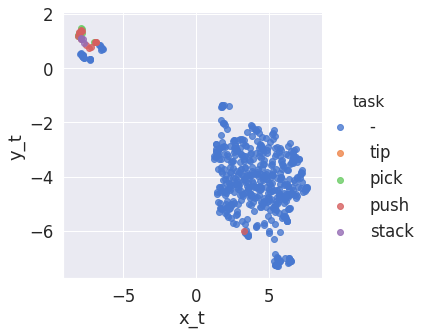

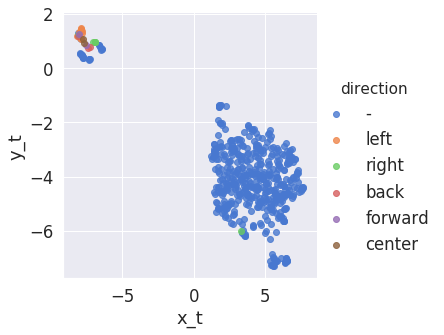

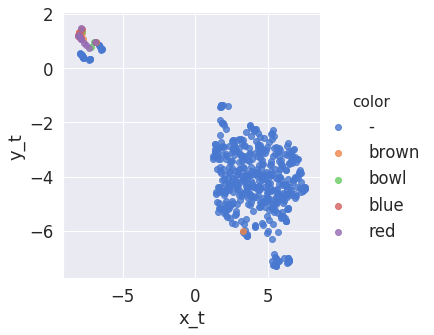

In [0]:
#@title UMAP Encoder Embedding Viz - these are all outside because the positive examples have different trajectory lengths 25-40 timesteps.
# reduced_embedding = TSNE().fit_transform(encoder_embeddings)
reduced_enc_embedding = umap.UMAP().fit_transform(encoder_embeddings)
df['x_t'] = reduced_enc_embedding[:,0]
df['y_t']  = reduced_enc_embedding[:,1]
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="x_t", y="y_t", data=df.iloc[::-1], fit_reg=False, hue='task', legend=True);
sns.lmplot( x="x_t", y="y_t", data=df.iloc[::-1], fit_reg=False, hue='direction', legend=True);
sns.lmplot( x="x_t", y="y_t", data=df.iloc[::-1], fit_reg=False, hue='color', legend=True);
# Move the legend to an empty part of the plot
# Move the legend to an empty part of the plot
#plt.legend(loc='lower right')

In [0]:
# Randomly sample a validation set example to visualize
idx = random.randint(TRAIN_LEN,TRAIN_LEN+VALID_LEN) # validation set
# idx = random.randint(0,TRAIN_LEN) # train set

In [0]:
idx = 51335

# Good performance with best best
# 54404 loss -21
# 

In [25]:
# #extension = '../data_and_weights/saved_models/semiregdbestbest'

extension = 'test_weights/BESTBESTdB0.0001-D0.Morelayers'
actor, planner, encoder = load_weights(extension, actor, planner, encoder)

Loading in network weights...
Loaded.


In [0]:
distribs = False # whether to visualise the dsitributions over each action dim at each timestep.

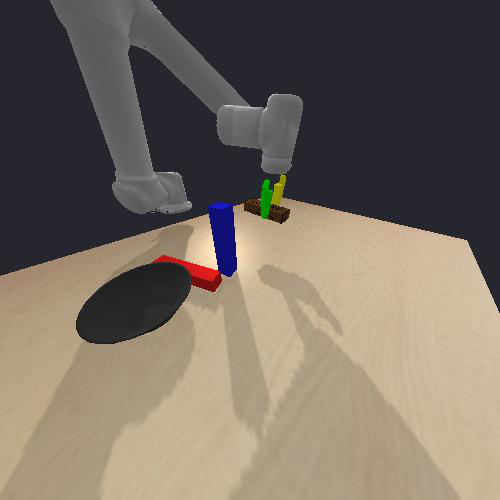

Imitation Loss was 591413.75


In [28]:
#@title Visualize robot state and action distribution over trajectory, for some reason colab only shows like 3/30 frames - but on local it shows all.

# Todo: Resampling of plans at 1Hz say when using sequences > SEQ_LEN
end = idx+MAX_SEQ_LEN
viz_unstandardised_obs = observations[idx:end][:,16:].copy().astype('float32') # for adding to the acitons if in relative.
seq_obs = standardized_obs[idx:end].astype('float32')
#seq_acts = actions_rounded[idx:end]
seq_acts = actions[idx:end].copy().astype('float32')
viz_imgs = []
img_paths = moments[idx:end]
for s in img_paths:
    viz_imgs.append(imageio.imread(s+'/standard_cam_left.jpg'))
    
viz_imgs = np.array(viz_imgs)
    
s_i = seq_obs[0]
s_g = seq_obs[-1]
s_i =  tf.expand_dims(tf.constant(s_i), axis = 0)
s_g =   tf.expand_dims(tf.constant(s_g), axis = 0)
mu, s = planner(s_i,s_g)
normal_plan = tfd.Normal(mu,s)
mu,s = encoder(tf.expand_dims(seq_obs, axis = 0), tf.expand_dims(seq_acts, axis=0))
normal_enc = tfd.Normal(mu,s)
# z = normal_plan.sample()
z = normal_enc.sample()

if DISCRETIZED:
    x = np.linspace(-128., 128., 256, dtype=np.float32)
else:
    x = np.linspace(-1., 1., 256, dtype=np.float32)



if RELATIVE:
    if DISCRETIZED:
        seq_acts = seq_acts/ (NUM_QUANTISATIONS/2) 
    seq_acts[:,:7] += viz_unstandardised_obs[:,:7]
        
a_plt = []
s_plt = []
imi_loss = 0 
for t in range(0,MAX_SEQ_LEN):
    
    s = seq_obs[t]
    a = seq_acts[t]
   
    
    s_unstandarized = tf.expand_dims(tf.constant(viz_unstandardised_obs[t]), axis = 0)
    s_plt.append(s_unstandarized[:7])
    
    s = tf.expand_dims(tf.constant(s), axis = 0)
    
    mu,scale, prob_weight, pdf,obs_pred= actor(s,z,s_g)
    
    if RELATIVE:
        grip = tf.expand_dims(mu[:,7,:], axis = 0)
        mu = tf.concat([mu[:,:7,:] + tf.expand_dims(s_unstandarized[:,:7],axis= 2),grip], axis = 1)  # add the current state to the action, so it's relative to current state.
    
    if distribs:
        fig, axes = plt.subplots(1, ACTION_DIM, figsize=(25,4), squeeze=False)
    a_pred =[]
    
    # create the disstributions from their paramters rather than directly taking the distribs because 
    # acessing elements by index is not implemented yet for quantized distributions - come on tensorflow team!
    for d in range(0,ACTION_DIM):
        if DISCRETIZED:
            discretized_logistic_dist = tfd.QuantizedDistribution(distribution=tfd.TransformedDistribution(
                distribution=tfd.Logistic(loc=mu[:,d,:]*NUM_QUANTISATIONS/4,scale=scale[:,d,:]),bijector=tfb.AffineScalar(shift=-0.5)),
            low=-NUM_QUANTISATIONS/2,
            high=NUM_QUANTISATIONS/2)

            gm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                    probs=prob_weight[:,d,:]),components_distribution=discretized_logistic_dist)
            
        else:
            logistic_dist = tfd.Logistic(loc=mu[:,d,:],scale=(scale[:,d,:])*0.00001)

            gm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                    probs=prob_weight[:,d,:]),components_distribution=logistic_dist)
            
        act = gm.sample()
        imi_loss += -gm.log_prob(seq_acts[t,d]) # the log probability of the true action under the distributed. 
        
        
        
        if RELATIVE:
            if DISCRETIZED:
                act = act / (NUM_QUANTISATIONS/2) # put the action back in it's true range because we want to add it to the state. 
            if act != 7:# if its not the gripper
                pass
               # act += s_unstandarized[:,d] # add the corresponding state
        
        a_pred.append(act) # add the action to the array holding all actions for the state
    
        
        if distribs:
            axes[0,d].plot(x, gm.prob(x));
            axes[0,d].axvline(x=a[d], c = 'r')


    a_plt.append(a_pred)
    clear_output(wait=True)
    pic = Image.fromarray(np.squeeze(viz_imgs[t,:,:,:]), 'RGB')
    if distribs:
        labels = ['x','y','z','q1','q2','q3','q4','gripper']
        for axis, label in zip(axes[0], labels):
          axis.set_title(label)
        plt.show()
    IPython.display.display(pic)
    #time.sleep(0.05)
a_plt = np.squeeze(np.array(a_plt))
s_plt = np.squeeze(np.array(s_plt))

print('Imitation Loss was', str(float(imi_loss)/MAX_SEQ_LEN))
    

In [0]:
seq_acts2 = seq_acts
a_plt2 = a_plt
s_plt2 = s_plt

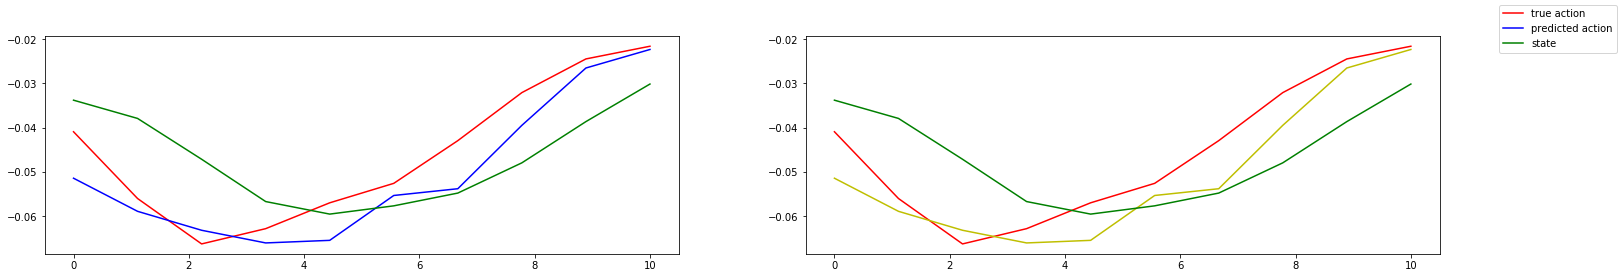

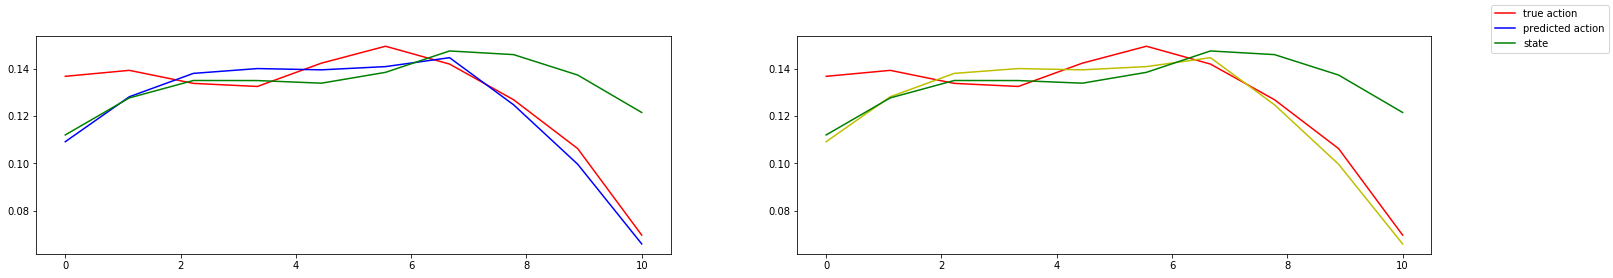

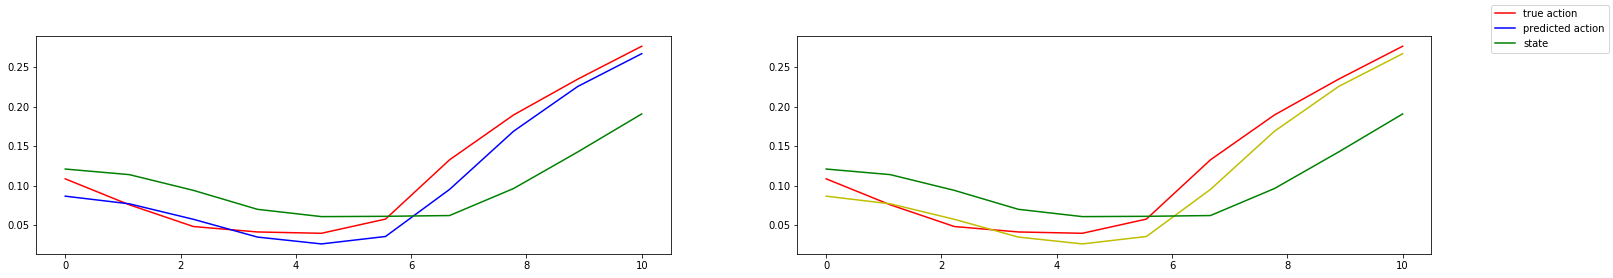

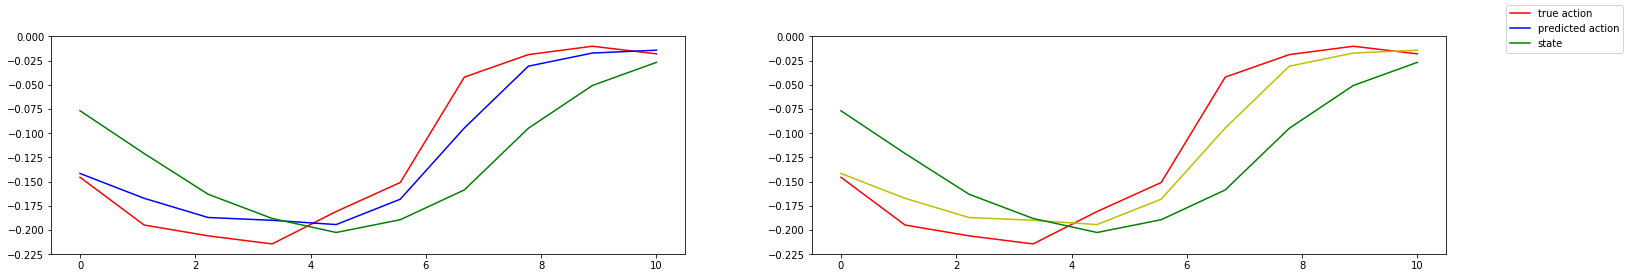

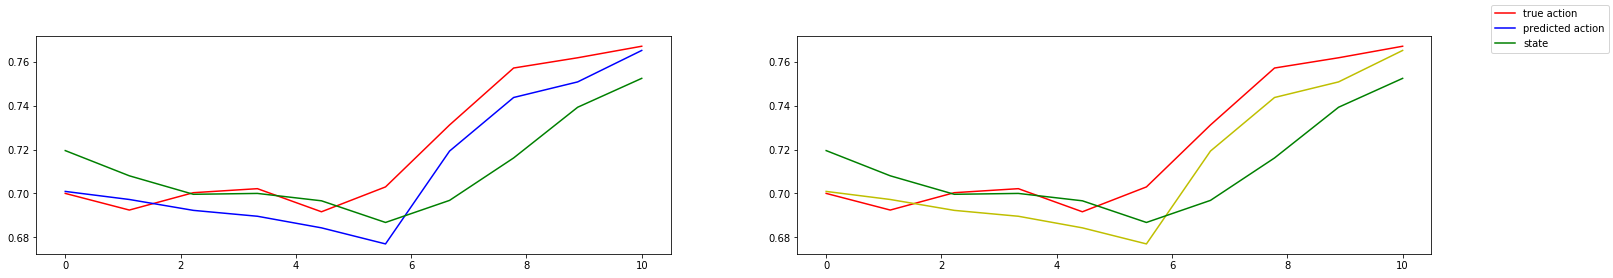

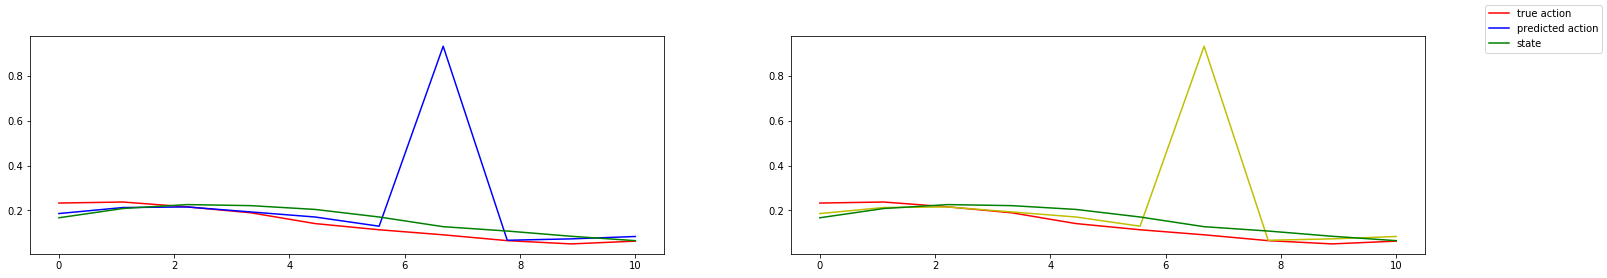

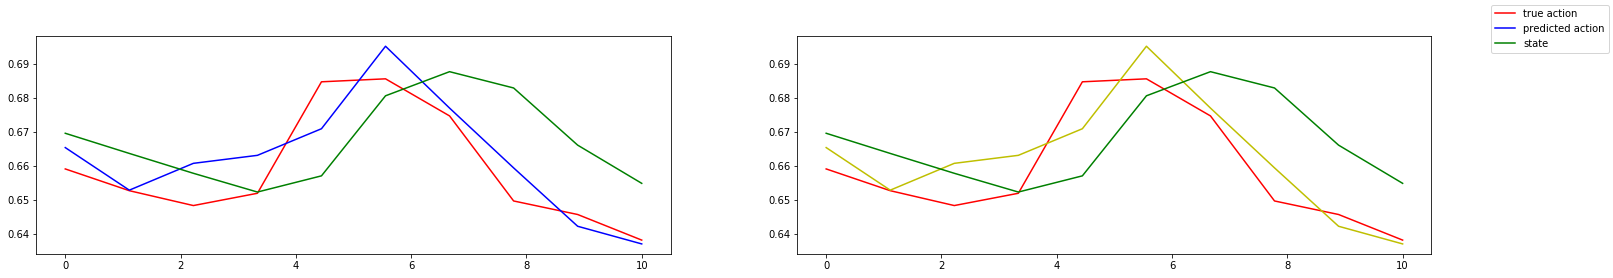

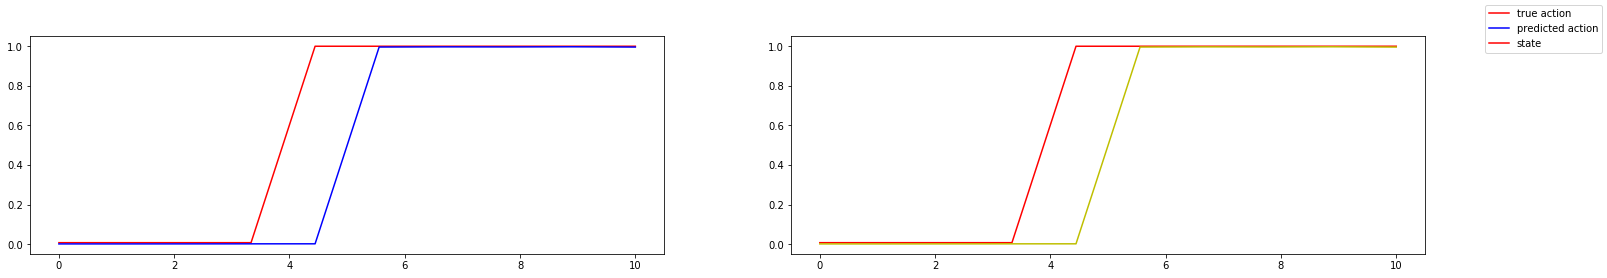

In [30]:
#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
length = seq_acts.shape[0]
actions_space = seq_acts.shape[1]
x = np.linspace(0, length, num=length) 
a.shape
for i in range(0,actions_space):
    
    fig, axes = plt.subplots(1, 2, figsize=(25,4), squeeze=False)
    # One Model
    true = axes[0,0].plot(x,seq_acts[:,i],'r')
    predicted = axes[0,0].plot(x,a_plt[:,i], 'b')
    if i != 7:
        state = axes[0,0].plot(x,s_plt[:,i], 'g')
        
    # another model
    true = axes[0,1].plot(x,seq_acts2[:,i],'r')
    predicted = axes[0,1].plot(x,a_plt2[:,i], 'y')
    if i != 7:
        state = axes[0,1].plot(x,s_plt2[:,i], 'g')
    
    fig.legend( ('true action', 'predicted action', 'state'))
    
    
    plt.show()
    

In [0]:
extension = '../saved_models/FINALB0_0001'+'SQL11'
actor, planner, encoder = load_weights(extension, actor, planner, encoder)

Loading in network weights...


ValueError: You are trying to load a weight file containing 5 layers into a model with 6 layers.

In [0]:
o_l = []
a_l = []

r = valid_dataset.shuffle(VALID_LEN).batch(BATCH_SIZE)
for valid_obs, valid_acts in r:
    o_l.append(valid_obs)
    a_l.append(valid_acts)
    

In [23]:
for idx, (valid_obs, valid_acts) in enumerate(zip(o_l, a_l)):
    
    IMI_val, KL_val = test_step(valid_obs, valid_acts)


    print(idx, IMI_val, KL_val, valid_obs.shape)

0 tf.Tensor(29.61272, shape=(), dtype=float32) tf.Tensor(180382.19, shape=(), dtype=float32) (256, 10, 35)
1 tf.Tensor(28.693226, shape=(), dtype=float32) tf.Tensor(188630.77, shape=(), dtype=float32) (256, 10, 35)
2 tf.Tensor(32.913204, shape=(), dtype=float32) tf.Tensor(186585.22, shape=(), dtype=float32) (256, 10, 35)
3 tf.Tensor(34.522945, shape=(), dtype=float32) tf.Tensor(185109.5, shape=(), dtype=float32) (256, 10, 35)
4 tf.Tensor(31.796146, shape=(), dtype=float32) tf.Tensor(184104.88, shape=(), dtype=float32) (256, 10, 35)
5 tf.Tensor(34.475986, shape=(), dtype=float32) tf.Tensor(180959.61, shape=(), dtype=float32) (256, 10, 35)
6 tf.Tensor(29.013767, shape=(), dtype=float32) tf.Tensor(181523.22, shape=(), dtype=float32) (256, 10, 35)
7 tf.Tensor(33.62316, shape=(), dtype=float32) tf.Tensor(184188.92, shape=(), dtype=float32) (256, 10, 35)
8 tf.Tensor(37.403896, shape=(), dtype=float32) tf.Tensor(183534.25, shape=(), dtype=float32) (256, 10, 35)
9 tf.Tensor(34.649574, shape=()

In [0]:
pdf[:,:7].log_prob(np.zeros([1,7]))

<tf.Tensor: id=298013, shape=(1, 7), dtype=float32, numpy=
array([[3.0575838, 2.8248832, 1.0945325, 2.364246 , 2.528781 , 2.5252247,
        2.738552 ]], dtype=float32)>

#Why does loss go negative?
Theretically, the probability an action comes from a distribution should be between 0 and 1, thus the log_prob should go from massively negative to 0. However, gm.prob() returns a positive number when given a number very very likely under the distribution. 

For example!


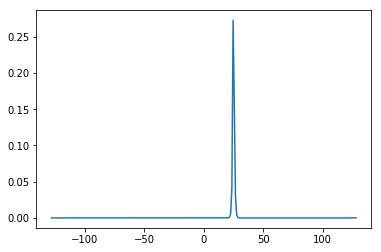

In [0]:
gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.3, 0.3, 0.4]),
    components_distribution=tfd.Logistic(
      loc=[25, 25, 25],       # One for each component.
      scale=[0.1, 0.1, 0.5]))  # And same here.

gm.mean()
# ==> 0.4

gm.variance()
# ==> 1.018

# Plot PDF.
x = np.linspace(-128., 128., 256, dtype=np.float32)
import matplotlib.pyplot as plt
plt.plot(x, gm.prob(x));
plt.show()

In [0]:
target = 24.0

print(gm.prob(target), 'since prob is >1, so is log_prob, thus -log_prob is negative')
print(-gm.log_prob(target))
print(gm.prob(24.8), 'as expected')

tf.Tensor(0.08426723, shape=(), dtype=float32) since prob is >1, so is log_prob, thus -log_prob is negative
tf.Tensor(2.4737623, shape=(), dtype=float32)
tf.Tensor(0.8221663, shape=(), dtype=float32) as expected
